# MIMIC-III ICU Mortality Prediction

## Author : Ashutosh Kumar
### Make sure PostgreSQL is up and running in the env and MIMIC database is created 


## Installing the required libraries to connect the jupyter notebook to PostgreSQL :

### Better way to achieve the installation 


!pip list --format=freeze > requirements.txt

##### _requirements.txt_ file for all the required dependencies has to be considered with other files :

In [1]:
### Created requirements.txt file for all the libraries :

In [66]:
!pip install -r requirements.txt

  Using cached Keras-2.1.6-py2.py3-none-any.whl (339 kB)
  Attempting uninstall: Keras
    Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0


In [67]:
# Importing the required libraries :

import numpy as np
from scipy import stats
import random as rn
rn.seed(1)
np.random.seed(1)
#from tensorflow import set_random_seed
#set_random_seed(1)

import psycopg2
import pandas as pd
pd.set_option('display.max_columns', 500)
import pandas.io.sql as psql
import pandas_profiling

from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from keras import backend as K
tf.random.set_seed(1) 

import itertools
import os
import getpass
import re

from keras import layers, regularizers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D
from keras.layers import AveragePooling2D, MaxPooling2D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.utils import resample

import keras.backend as K
K.set_image_data_format('channels_last')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

GPU_list = tf.config.list_physical_devices('GPU')
#GPU_list = tf.test.gpu_device_name()
print("GPU list:", GPU_list)

# plot a figure directly on Notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

GPU list: []


In [4]:
# checking the version of installed libraries : 

import pkg_resources

pkg_resources.get_distribution('tensorflow').version 
##'2.3.0'

pkg_resources.get_distribution('numpy').version
##'1.19.2'

pkg_resources.get_distribution('pandas').version
## '1.2.1'

pkg_resources.get_distribution('deeplift').version
## '0.6.13.0'

pkg_resources.get_distribution('matplotlib').version
## '3.3.3'

pkg_resources.get_distribution('keras').version
## '2.4.3'

##pkg_resources.get_distribution('modin').version

'2.2.0'

### Using psycopg2

In [5]:
import psycopg2
conn = psycopg2.connect(database="mimic", user = "postgres", password = "Austin@316", host = "localhost", port = "5432")
print("Opened database connection successfully")

Opened database connection successfully


In [6]:
# This code is adapted from the tutorial hosted below:
# http://www.postgresqltutorial.com/postgresql-python/connect/

# import psycopg2

# Establish a connection to the database by creating a cursor object
# The PostgreSQL server must be accessed through the PostgreSQL APP or Terminal Shell

def run_sql_query(sql_statement):
    conn = psycopg2.connect(database="mimic", user = "postgres", password = "Austin@316", host = "localhost", port = "5432")

# Create a cursor object
    cur = conn.cursor()

    cur.execute(sql_statement)
    query_results = cur.fetchall()
    return query_results

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
    cur.close()
    conn.close()

In [7]:
sql_statement= """
SELECT * from mimiciii.patients
limit 2
"""
test_result = run_sql_query(sql_statement)
print(test_result)

[(234, 249, 'F', datetime.datetime(2075, 3, 13, 0, 0), None, None, None, 0), (235, 250, 'F', datetime.datetime(2164, 12, 27, 0, 0), datetime.datetime(2188, 11, 22, 0, 0), datetime.datetime(2188, 11, 22, 0, 0), None, 1)]


### The better way using "psycopg2" and modular enterprise level code :

##### Please make sure that the "database.ini", "config.py" and "gitignore" files are present as applicable with this ipynb file

In [8]:
# The following connect() function connects to the mimic database and prints out the PostgreSQL database version:

#!/usr/bin/python
import psycopg2
from config import config

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)

        # create a cursor
        cur = conn.cursor()
        
# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)

# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')


if __name__ == '__main__':
    connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 10.15, compiled by Visual C++ build 1800, 64-bit',)
Database connection closed.


In [9]:
# This Python script connects to a PostgreSQL database and utilizes Pandas to obtain data and create a data frame
# A initialization and configuration file is used to protect the author's login credentials

import psycopg2
import pandas as pd

# Import the 'config' funtion from the config.py file
from config import config

# Establish a connection to the database by creating a cursor object

# Obtain the configuration parameters
params = config()
# Connect to the PostgreSQL database
conn = psycopg2.connect(**params)
# Create a new cursor
cur = conn.cursor()

# A function that takes in a PostgreSQL query and outputs a pandas database 
def create_pandas_dataframe(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table
  
# Utilize the create_pandas_table function to create a Pandas data frame
# Store the data as a variable
test_df = create_pandas_dataframe(""" SELECT * FROM MIMICIII.patients
                                    LIMIT 10 """)

print("Operation done successfully, below are results :");
#print(test_df)

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
cur.close()
conn.close()

Operation done successfully, below are results :


In [10]:
test_df.head(2)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1


In [11]:
#  First some styling
plt.style.use('ggplot')
palette = plt.get_cmap('tab10')

In [12]:
# Defining some utility functions :


In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.gca().grid(False)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    return fpr, tpr, thr

def cross_validation_plot_roc_curve(ground_truth, predictions, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for g, p in zip(ground_truth, predictions):
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = g, y_score = p, drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return mean_fpr, mean_tpr
    
def print_classification_report(ground_truth, predictions):
    print(classification_report(ground_truth, predictions, target_names=['die'], labels=[1]))

In [62]:
# Some important values
#inputs_filename = 'MIMICIII_dataset_inputs.pickle'
#outputs_filename = 'MIMICIII_dataset_mortality_labels.pickle'
inputs_filename = 'MIMICIII_dataset_inputs.pkl'
outputs_filename = 'MIMICIII_dataset_mortality_labels.pkl'
split_data = False
model_factories = dict()

In [63]:
# let's load the dataset into the form of pickle files from postgresql database :



In [64]:
def load_dataset(inputs_filename, labels_filename):
    if not os.path.exists(inputs_filename):
        user = 'postgres'
        host = 'localhost'
        dbname = 'mimic'
        schema = 'mimiciii'
        passwd = 'Austin@316'
        con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                           password=passwd)
        cur = con.cursor()
        cur.execute('SET search_path to {}'.format(schema))
        query = '''
        SELECT *, FLOOR(icu_time_hr) AS measurement_hour, 
        CASE WHEN AGE > 80.0 then 80 else AGE end as corrected_age
        FROM mimiciii.datasetsapsii 
        WHERE measurement_name IS NOT NULL AND value IS NOT NULL ORDER BY subject_id
        '''
        data = pd.read_sql_query(query, con)
        data = data[data.measurement_hour != 48]
        print("Number of rows: {0}".format(data.shape[0]))
        #Get ground truth
        mortality_labels = data.drop_duplicates(subset=['subject_id'])[['subject_id','mort_icu']]
        #Sort so it matches the inputs order
        #mortality_labels.sort_values(by='subject_id', inplace=True)
        print("Number of distinct IDs: {0}".format(mortality_labels.shape[0]))
        
        #Pivot data into a stacked PTS representation
        #Any measurements from the same hour will be averaged, except urine output which we'll sum up
        inputs = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                      columns='measurement_hour', values='value', aggfunc=[np.mean, np.sum])
        
        mean_table = inputs['mean']
        sum_table = inputs['sum']
        mean_table[mean_table.index.get_level_values('measurement_name') 
                   == 'URINE'] = sum_table[sum_table.index.get_level_values('measurement_name')
                                           == 'URINE']
        
        inputs = mean_table
                                           
        print("Number of distinct IDs after pivoting: {0}".format(inputs.index.levels[0].shape[0]))
        
        #Add rest of SAPS-II variables - clunky and inefficient but works
        data['measurement_name'] = 'AGE'
        ages = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='corrected_age', aggfunc=np.mean)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'SURGICAL'
        surgical = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='surgical', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'ELECTIVE'
        elective = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='elective', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'AIDS'
        aids = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='aids', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'METASTATIC_CANCER'
        metastatic_cancer = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='metastatic_cancer', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'LYMPHOMA'
        lymphoma = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='lymphoma', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        sapsII_inputs = pd.concat([inputs, ages, surgical, elective, aids, metastatic_cancer, lymphoma]).sort_index()
        print("Number of distinct IDs after adding extra variables: {0}".format(sapsII_inputs.index.levels[0].shape[0]))

        #Generate missing series for each patient
        
        index_names = sapsII_inputs.index.names
        new_index = pd.MultiIndex.from_product(sapsII_inputs.index.levels)
        new_index.names = index_names
        sapsII_inputs = sapsII_inputs.reindex(new_index)
        
        print("Number of distinct series after re-indexing: {0}".format(sapsII_inputs.index.levels[1].shape[0]))
        print("Number of distinct hours after re-indexing: {0}".format(sapsII_inputs.shape[1]))
        print("Number of distinct IDs after re-indexing: {0}".format(sapsII_inputs.index.levels[0].shape[0]))
        
        
        #Save everything
        sapsII_inputs.to_pickle(inputs_filename)
        mortality_labels.to_pickle(outputs_filename)
        
        con.close()
    else:
        sapsII_inputs = pd.read_pickle(inputs_filename);
        mortality_labels = pd.read_pickle(outputs_filename)
    
    return sapsII_inputs, mortality_labels

In [65]:
input_dataframe, labels_dataframe = load_dataset(inputs_filename, outputs_filename)

In [66]:
# A sanity check:

In [67]:
id2 = labels_dataframe['subject_id'].values
id1 = input_dataframe.index.levels[0].values
print(np.setdiff1d(id2,id1))
labels_dataframe.head(10)

[]


,subject_id,mort_icu
0,3,0
842,6,0
1124,9,1
1570,12,0
1965,13,0
2661,17,0
2956,21,0
3274,25,0
3587,26,0
3779,31,1


In [68]:
# Imputation :

In [69]:
#GCS and Fi02 data are imputed to their normal values
#For urine is it better to impute mean, or include an imputation mask
input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSEyes'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSEyes'].fillna(method='ffill', axis=1)#.fillna(value=4) 

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSMotor'] = \
input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSMotor'].fillna(method='ffill', axis=1)#.fillna(value=6)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSVerbal'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSVerbal'].fillna(method='ffill', axis=1)#.fillna(value=5)

#input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'URINE OUTPUT'] = \
#    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'URINE OUTPUT'].fillna(value=0)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'FiO2'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'FiO2'].fillna(method='ffill', axis=1).fillna(value=0.2)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'PO2'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'PO2'].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

#Now the rest of NAs are filled
#NOTE: Some NAs will remain, specifically if there is not even one measurement, all values for that particular variable will still be NAs
input_dataframe = input_dataframe.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

In [70]:
# cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=None)
cv_idx = list(cv.split(X=np.zeros(labels_dataframe.shape[0]), y=labels_dataframe['mort_icu'].values))

In [71]:
cv_idx

[(array([ 4433,  4466,  4474, ..., 22410, 22411, 22412]),
  array([   0,    1,    2, ..., 4484, 4486, 4487])),
 (array([    0,     1,     2, ..., 22410, 22411, 22412]),
  array([4433, 4466, 4474, ..., 9008, 9009, 9010])),
 (array([    0,     1,     2, ..., 22410, 22411, 22412]),
  array([ 8518,  8522,  8527, ..., 13513, 13514, 13515])),
 (array([    0,     1,     2, ..., 22410, 22411, 22412]),
  array([12798, 12812, 12818, ..., 17980, 17981, 17982])),
 (array([    0,     1,     2, ..., 17980, 17981, 17982]),
  array([17512, 17515, 17539, ..., 22410, 22411, 22412]))]

In [72]:
# Save fold means and deviations to standardize later

In [73]:
fold_mean = []
fold_std = []

for train, validation in cv_idx:
    fold = input_dataframe.loc[train]
    
    mean = fold.mean(level='measurement_name').mean(axis=1)
    std = fold.std(level='measurement_name').mean(axis=1)
    #Store training fold mean and std to standardize validation folds later
    #Extra dimension is added to make broadcasted division and subtraction possible
    fold_mean.append(mean.values[:, None]) 
    fold_std.append(std.values[:, None])

KeyError: '[ 4466  4476  4485 ... 22409 22410 22411] not in index'

## Creating a database connection:

In [12]:
# Information used to create a database connection

sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
host = 'localhost'
passwd = 'Austin@316'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=host, 
                           password=passwd)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

#cur = con.cursor()
#cur.execute('SET search_path to {}'.format(schema))

# 1. Preprocessing and EDA  :

## 1.1 Cohort Selection:

###  MIMICIII ICUSTAYS Table :  
Defines each ICUSTAY_ID in the database, i.e. defines a single ICU stay.

###  MIMICIII PATIENTS Table :  
Defines each SUBJECT_ID in the database, i.e. defines a single patient.

In [13]:
# Find the different SUBJECT_ID individual patients:

# cur.execute("""SELECT distinct subject_id from MIMICIII.patients""")

sql_statement1= """
SELECT distinct count(subject_id)from MIMICIII.icustays
"""

test_result1 = run_sql_query(sql_statement1)
print("Total number of distinct patients are :",test_result1)


Total number of distinct patients are : [(61532,)]


### So, there are total 61532 patients. 

In [14]:
# Apply the 1st preprocessing where to consider the stays are atleast 48 hours in ICU : 

query = query_schema + """
WITH co AS
(
SELECT subject_id, hadm_id, icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay_days
FROM icustays
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay_days
FROM co
WHERE icu_length_of_stay_days >= 2
"""
icustays_df = pd.read_sql_query(query, con)
icustays_df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay_days
0,268,110404,280836,3.248993
1,269,106296,206613,3.278796
2,270,188028,220345,2.893854
3,271,173727,249196,2.059977
4,274,130546,254851,8.814259


In the above, seconds are converted to days easily by dividing by: 60 (seconds in a minute), 60 (minutes in an hour), and 24 (hours in a day). We also omit the icu_length_of_stay_interval as it's now redundant for our purposes.

If we are only interested in ICU stays lasting a certain length (say 24 hours), we need to do the following two steps:

use an in-line view to "hold" the data
use the WHERE clause to filter this data using our generated column
Here's an example of us filtering to only stays lasting at least 2 days:

Note that the EXTRACT(EPOCH FROM ... ) code extracts the number of fractional seconds represented by an interval data type.
So the logic is roughly intime - outtime -> icu_length_of_stay_interval, followed by EXTRACT(EPOCH FROM 
icu_length_of_stay_interval) -> fractional seconds (numeric). ICU Length of stay is most readily interpretted when represented
in fractional days or hours, so let's do that conversion.

In [15]:
# Defining a common function for the distribution plot visualisation:

def plot_distplot(dataframe,column,title):
    fig = plt.figure(figsize=(7,4))
    plt.title(title)
    ax = sns.distplot(dataframe[column], hist=True, color='#2b7bba')
    plt.show()
    
    
def plot_histogram(dataframe,column,title,xlabel,ylabel,bins):
    fig = plt.figure(figsize=(7,4))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns.set()
    plt.hist(dataframe[column],bins=bins)
    plt.show()

In [16]:
icustays_df.describe()

,subject_id,hadm_id,icustay_id,icu_length_of_stay_days
count,32311.000000,32311.000000,32311.000000,32311.000000
mean,32902.744607,149920.819380,249958.375228,8.392433
std,27821.242834,28925.733371,28807.976509,12.297022
min,3.000000,100001.000000,200001.000000,2.000012
25%,11628.500000,124916.500000,225077.500000,2.841019
50%,23454.000000,149804.000000,250117.000000,4.218970
75%,52114.000000,175083.000000,274805.500000,8.499491
max,99995.000000,199999.000000,299995.000000,173.072512


Minimum is 2 days and Maximum duration is 173 days of the stay. Mean ICU stay is 8.39 Days before any outcome of patient stay.
So the total distinct subjects as of now are 32311 in number after applying first entry criteria.

Looks good - none of the above stays are shorter than 2 days.

Many studies using the MIMIC-III database are focused on specific subgroups of patients. For example, MIMIC-III contains both adults and neonates, but it is rare that a study would like to evaluate some phenomenom in both groups simulatenously. As a result, the first step of many studies is selecting a subpopulation from the icustays table. Concretely, we will want to select a set of icustay_id which represent our patient population. You've just seen an example of doing this: in the above code, we limited our population to only those who were in the ICU for at least 2 days.

When subselecting the patient population, it is generally good practice to build a "cohort" table - that is a table with all icustay_id available in the database, each associated with binary flags indicating whether or not they are excluded from your population. Let's take a look at how this would work with the above query which limited the dataset to patients who stayed longer than 2 days.

In [17]:
query = query_schema + """
WITH co AS
(
SELECT subject_id, hadm_id, icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay_days
FROM icustays
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay_days
  , CASE
        WHEN co.icu_length_of_stay_days < 2 then 1
    ELSE 0 END
        as exclusion_los
FROM co
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay_days,exclusion_los
0,268,110404,280836,3.248993,0
1,269,106296,206613,3.278796,0
2,270,188028,220345,2.893854,0
3,271,173727,249196,2.059977,0
4,272,164716,210407,1.620243,1


This is a good practice to have all data with the exclsuion_flag as it will make it very easy to summarize your exclusions at the end of your study and modify them if your later work deems it necessary.

Let's go back to the common exclusion criteria mentioned earlier: flagging non-adults for removal. First, we'll need to calculate the patient's age on ICU admission, which will require the patient's date of birth and the ICU admission time. We already have the ICU admission time (intime in the icustays table), so all we need to do is get the date of birth from the patients table

In [18]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay_days
, icu.intime - pat.dob AS age
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
LIMIT 10
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay_days
  , co.age
  , CASE
        WHEN co.icu_length_of_stay_days < 2 then 1
    ELSE 0 END
        as exclusion_los
FROM co
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay_days,age,exclusion_los
0,2,163353,243653,0.091829,0 days 21:20:07,1
1,3,145834,211552,6.064560,27950 days 19:10:11,0
2,4,185777,294638,1.678472,17475 days 00:29:31,1
3,5,178980,214757,0.084444,0 days 06:04:24,1
4,6,107064,228232,3.672917,24084 days 21:30:54,0


Notes from the above query: we have to specify the table in icu.subject_id because there is a subject_id column in both the icustays table and the patients table, and the program doesn't know which we want unless we specify it.

Now, looking at the results, it appears age is returned as the number of days between the dob and the intime - perhaps not what we desire! As mentioned before, this is an interval data type - it's useful when doing date operations but for our purposes it is not practical. We have three options:

we can use the function EXTRACT() to extract the seconds and convert that into an age by dividing by the number of seconds in a year (as we did before)
we can use the PostgreSQL function AGE() to return a symbolic representation of the age in years followed by the function DATE_PART() to extract the years
the same as the above, but calling DATE_PART() to get the months and days as well for more precision
Let's look at all three.

In [19]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay_days
, icu.intime - pat.dob AS age
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
LIMIT 10
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay_days
  , co.age
  , EXTRACT('year' FROM co.age) as age_extract_year 
  , EXTRACT('year' FROM co.age) 
    + EXTRACT('months' FROM co.age) / 12.0
    + EXTRACT('days' FROM co.age) / 365.242
    + EXTRACT('hours' FROM co.age) / 24.0 / 364.242
    as age_extract_precise
  , EXTRACT('epoch' from co.age) / 60.0 / 60.0 / 24.0 / 365.242 as age_extract_epoch
  , CASE
        WHEN co.icu_length_of_stay_days < 2 then 1
    ELSE 0 END
        as exclusion_los
FROM co
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay_days,age,age_extract_year,age_extract_precise,age_extract_epoch,exclusion_los
0,2,163353,243653,0.091829,0 days 21:20:07,0.0,0.002402,0.002434,1
1,3,145834,211552,6.064560,27950 days 19:10:11,0.0,76.526779,76.526792,0
2,4,185777,294638,1.678472,17475 days 00:29:31,0.0,47.844990,47.845047,1
3,5,178980,214757,0.084444,0 days 06:04:24,0.0,0.000686,0.000693,1
4,6,107064,228232,3.672917,24084 days 21:30:54,0.0,65.942245,65.942297,0


As we can see, there is very little difference between the second and last approach - so it is up to preference (and desire for true precision). We will use the EXTRACT('epoch' ... ) approach as it's the simplest.

Now, we will filter out neonates by requiring age to be greater than 16 (note while this also removes children, there are no children in the MIMIC-III database).

### 1.1.1 Applying filter to remove the neonates of age less than 16 year:

In [20]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
        as exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
        as exclusion_age
FROM co
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,exclusion_los,exclusion_age
0,268,110404,280836,3.248993,65.986326,0,0
1,269,106296,206613,3.278796,40.100706,0,0
2,270,188028,220345,2.893854,80.080135,0,0
3,271,173727,249196,2.059977,45.687427,0,0
4,272,164716,210407,1.620243,67.097652,1,0


### 1.1.2 Applying filter to consider only the 1st admission in case of readmissions :

Let's try another common exclusion criteria: secondary admissions to the ICU - either in-hospital or out of hospital. The primary reason for this is it simplifies many statistical analyses which assume independent observations. If we kept multiple ICU stays for the same patient, then we would have to account for the fact that these ICU stays are highly correlated (e.g. the same patient may repeatedly be admitted for the same condition), and this can add an undesirable layer of complexity. To identify readmissions, we first rank ICU stays from earliest to latest using the RANK() function.

In [21]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age

, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order

FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , co.icustay_id_order
  
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
        as exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
        as exclusion_age
FROM co
"""
df = pd.read_sql_query(query, con)
df.head(10)

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,exclusion_los,exclusion_age
0,2,163353,243653,0.091829,0.002434,1,1,1
1,3,145834,211552,6.064560,76.526792,1,0,0
2,4,185777,294638,1.678472,47.845047,1,1,0
3,5,178980,214757,0.084444,0.000693,1,1,1
4,6,107064,228232,3.672917,65.942297,1,0,0
5,7,118037,278444,0.267720,0.001779,1,1,1
6,7,118037,236754,0.739097,0.005868,2,1,1
7,8,159514,262299,1.075521,0.001438,1,1,1
8,9,150750,220597,5.323056,41.790228,1,0,0
9,10,184167,288409,8.092106,0.001329,1,0,1



We can see that subject_id = 7 has been admitted twice - we would like to exclude this second admission, so we code in a CASE statement to do exactly this (note: while the subject would be excluded anyway, due to the other exclusion criteria, it's still a good example case!).

In [22]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age

, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order

FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
LIMIT 10
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , co.icustay_id_order
  
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
FROM co
"""
df = pd.read_sql_query(query, con)
df

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,exclusion_los,exclusion_age,exclusion_first_stay
0,2,163353,243653,0.091829,0.002434,1,1,1,0
1,3,145834,211552,6.064560,76.526792,1,0,0,0
2,4,185777,294638,1.678472,47.845047,1,1,0,0
3,5,178980,214757,0.084444,0.000693,1,1,1,0
4,6,107064,228232,3.672917,65.942297,1,0,0,0
5,7,118037,278444,0.267720,0.001779,1,1,1,0
6,7,118037,236754,0.739097,0.005868,2,1,1,1
7,8,159514,262299,1.075521,0.001438,1,1,1,0
8,9,150750,220597,5.323056,41.790228,1,0,0,0
9,10,184167,288409,8.092106,0.001329,1,0,1,0


In [23]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age

, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order

FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , co.icustay_id_order
  
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
FROM co
"""
df_icu_stays_patients = pd.read_sql_query(query, con)
df_icu_stays_patients.head(10)

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,exclusion_los,exclusion_age,exclusion_first_stay
0,2,163353,243653,0.091829,0.002434,1,1,1,0
1,3,145834,211552,6.064560,76.526792,1,0,0,0
2,4,185777,294638,1.678472,47.845047,1,1,0,0
3,5,178980,214757,0.084444,0.000693,1,1,1,0
4,6,107064,228232,3.672917,65.942297,1,0,0,0
5,7,118037,278444,0.267720,0.001779,1,1,1,0
6,7,118037,236754,0.739097,0.005868,2,1,1,1
7,8,159514,262299,1.075521,0.001438,1,1,1,0
8,9,150750,220597,5.323056,41.790228,1,0,0,0
9,10,184167,288409,8.092106,0.001329,1,0,1,0


As we can see, we are now excluding this later admission.


#### Visualising the distribution of the ICU Length of stay in days 

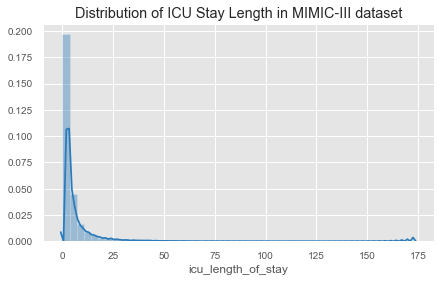

In [24]:
plot_distplot(df_icu_stays_patients,"icu_length_of_stay","Distribution of ICU Stay Length in MIMIC-III dataset")

The length of stay is between 0 to 10 days for maximum patients in the given dataset.

#### Visualising the distribution of age of the patients

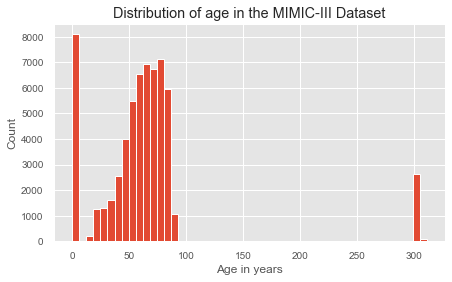

In [25]:
plot_histogram(df_icu_stays_patients,"age","Distribution of age in the MIMIC-III Dataset","Age in years","Count",50)

The plot shows presence of neonates and non-adult patients in the original dataset.

Dates of birth for patients aged over 89 years were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years.

### MIMICIII ADMISSIONS Table :
The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on

In [86]:
# Reading the data directly from CSV instead of using the psycopg2:

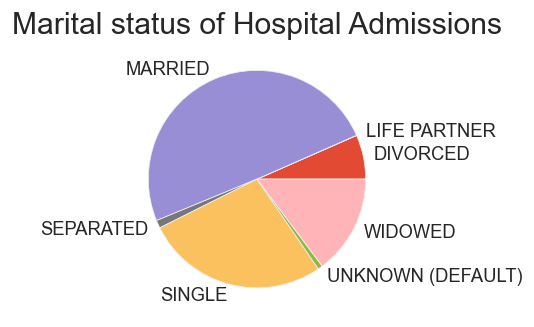

In [26]:
fig = plt.figure(figsize=(3,3), dpi=120)
ax = plt.subplot(111)
#ax.set_ylabel(None)

# Use specific style :
plt.style.use('ggplot')

a = pd.read_csv(r"C:\mimic-iii-clinical-database-1.4/ADMISSIONS.csv")
a.columns = map(str.lower, a.columns)
a.groupby(['marital_status']).count()['row_id'].plot(kind='pie',ax=ax)

plt.ylabel(None)
plt.title("Marital status of Hospital Admissions",size=18)
plt.show()


More than half of the patients are Married, followed by Single and Widowed patients respectively. Least number of patients are having the marital status of Unknown and Separated.

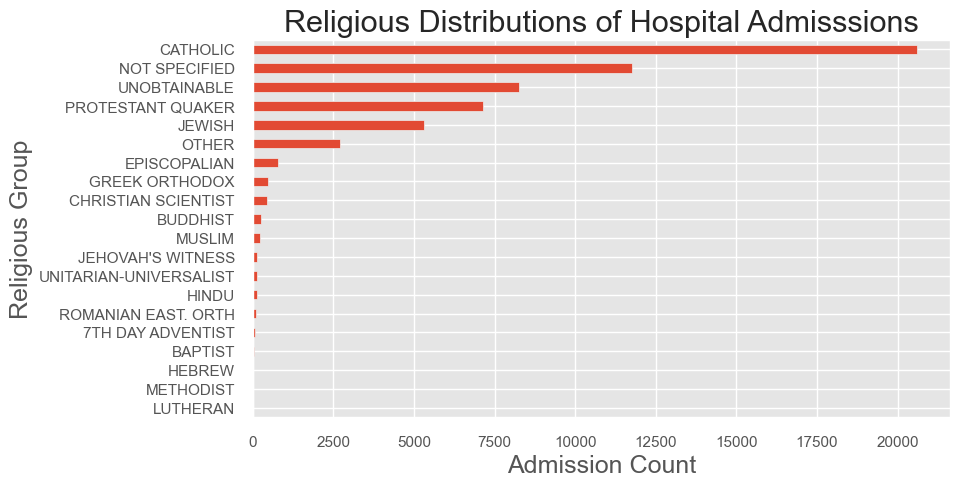

In [27]:
fig = plt.figure(figsize=(9,5), dpi=100)
ax = plt.subplot(111)

# b= a.groupby(['religion']).count()['row_id'].plot(kind = 'barh')
b= a.groupby(['religion']).count()['row_id']
b = b.drop(b[b == 0].index).sort_values(ascending=True)
b.plot(kind = 'barh')

# Use specific style :
plt.style.use('seaborn-ticks')

plt.ylabel("Religious Group",size=18)
plt.xlabel("Admission Count",size=18)
plt.title("Religious Distributions of Hospital Admisssions",size=22)
plt.show()


Most number of admissions belongs to Catholic religious groups. This is followed by the unspecifed/undeclared group of 
individuals whose religious information is missing belonging to the "Unobtainable" and "Not Specified" group.  
The Lutheran, Methodist and Herbrew religious people are least in number who were admitted. 

### DIAGNOSIS Information from free text data of ADMISSIONS Table :

The DIAGNOSIS column provides a preliminary, free text diagnosis for the patient on hospital admission. The diagnosis is usually assigned by the admitting clinician and does not use a systematic ontology. As of MIMIC-III v1.0 there were 15,693 distinct diagnoses for 58,976 admissions. The diagnoses can be very informative (e.g. chronic kidney failure) or quite vague (e.g. weakness). Final diagnoses for a patient’s hospital stay are coded on discharge and can be found in the DIAGNOSES_ICD table. While this field can provide information about the status of a patient on hospital admission, it is not recommended to use it to stratify patients

#### Creating wordcloud for Preliminary Diagnosis Information:

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

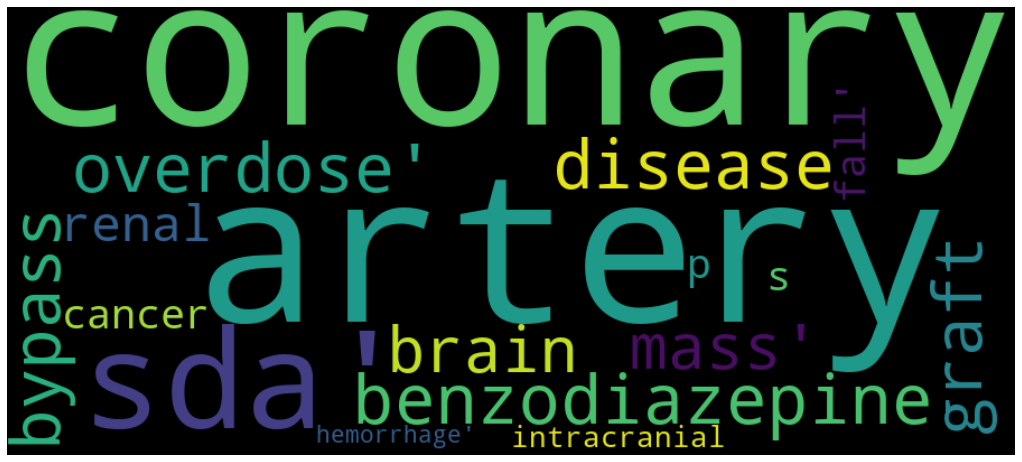

In [28]:
# Prepare an input text in string :
text = str(a['diagnosis'].values)

# Create StopWords:
stopwords = set(STOPWORDS)
comment_words = ''

# split the value
tokens = text.split()
    
# Converts each token into lowercase
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()

comment_words += " ".join(tokens)+" "

# Generate a word-cloud from the input text:
wordcloud = WordCloud(width = 900, height = 400,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10,
                max_words=100).generate(comment_words)


# Plot the word-cloud:
plt.figure(figsize = (14,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

From the image, we can clearly see the top ten topics are "coronary", "artery", "sda", "bypass", "disease", "brain", "graft", "overdose","benzodiazepine" and "cancer" respectively. One can clearly see how useful a word cloud is to identify the top words in a collection of text.

### "Missingno" visualization of missing data in the ADMISSIONS Table: 

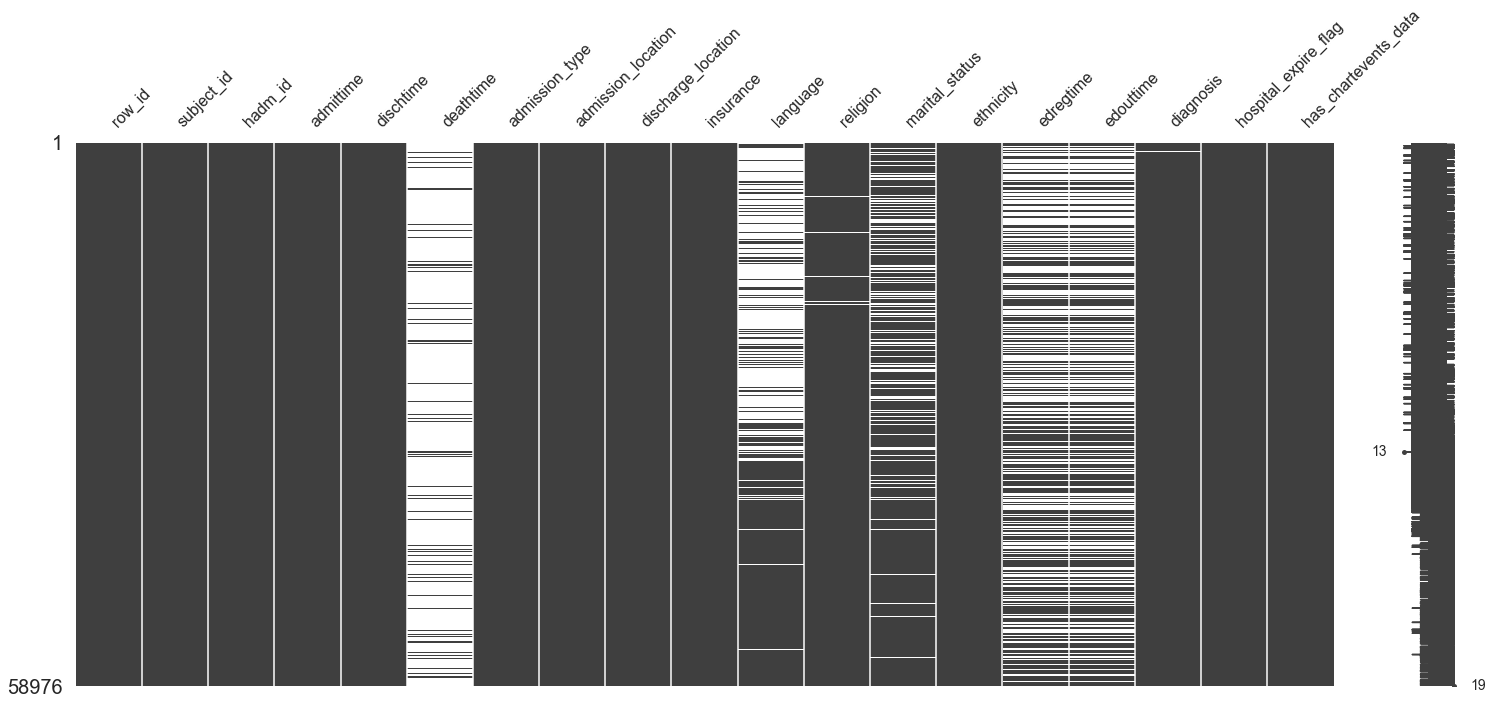

In [29]:
import missingno as msno
msno.matrix(a)

**Missingno** offers a visual summary of the completeness of a dataset. This example brings some intuitive thoughts about **ADMISSIONS** table:

> Not every patient is admitted to the emergency department as there are many missing values in edregtime and edouttime.  
> language data of patients is mendatory field, but it used to be not.

### Understanding the admission type and admission location :
Please refer the postgreSQL snapshot output for the same.  (excel)  

Which is an interesting view of the data! In particular, we can see some sensible counts. Elective patients and newborn patients are never admitted from the emergency room. Interestingly, urgent patients are never admitted from the emergency room either, which helps highlight the subtle differences between EMERGENCY and URGENT.

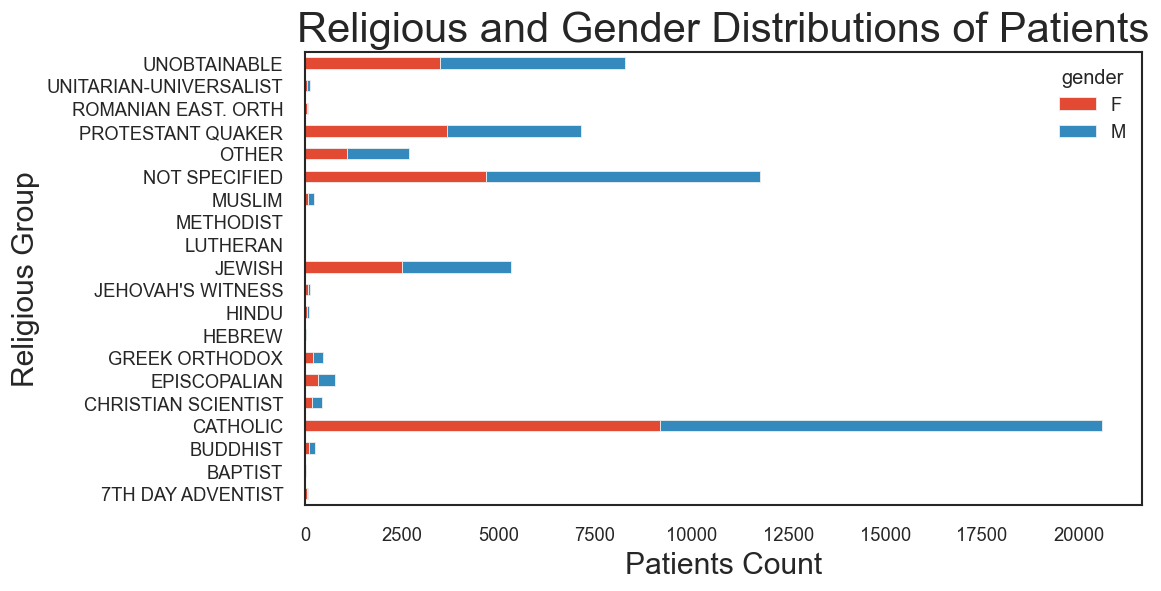

In [30]:
fig = plt.figure(figsize=(9,5), dpi=120)
ax = plt.subplot(111)

p = pd.read_csv(r"C:\mimic-iii-clinical-database-1.4/PATIENTS.csv")
p.columns = map(str.lower, p.columns)

# Merging the ADMISSIONS table with PATIENTS table:
ap = pd.merge(a, p, on = 'subject_id' , how = 'inner')
ap.groupby(['religion','gender']).size().unstack().plot(kind="barh", stacked=True, ax=ax)

# Use specific style :
plt.style.use('seaborn')

plt.ylabel("Religious Group",size=18)
plt.xlabel("Patients Count",size=18)
plt.title("Religious and Gender Distributions of Patients",size=25)
plt.show()

Catholic religious group have the largest number of patients and Male patients dominates almost all the religious groups.

### MIMICIII SERVICES Table :

The SERVICES table should be used if interested in identifying the type of service a patient is receiving in the hospital.  
The services table describes the service that a patient was admitted under. While a patient can be physicially located at a given ICU type (say MICU), they are not necessarily being cared for by the team which staffs the MICU. This can happen due to a number of reasons, including bed shortage. The SERVICES table should be used if interested in identifying the type of service a patient is receiving in the hospital. For example, if interested in identifying surgical patients, the recommended method is searching for patients admitted under a surgical service.

In [31]:
query = query_schema + """
SELECT subject_id, hadm_id, transfertime, prev_service, curr_service
FROM services
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,transfertime,prev_service,curr_service
0,471,135879,2122-07-22 14:07:27,TSURG,MED
1,471,135879,2122-07-26 18:31:49,MED,TSURG
2,472,173064,2172-09-28 19:22:15,None,CMED
3,473,129194,2201-01-09 20:16:45,None,NB
4,474,194246,2181-03-23 08:24:41,None,NB


In [32]:
df_temp_services = df.groupby(['curr_service']).size().reset_index(name='counts').sort_values('counts')
df_temp_services.head()

,curr_service,counts
15,PSYCH,1
2,DENT,5
11,OBS,113
3,ENT,247
14,PSURG,283


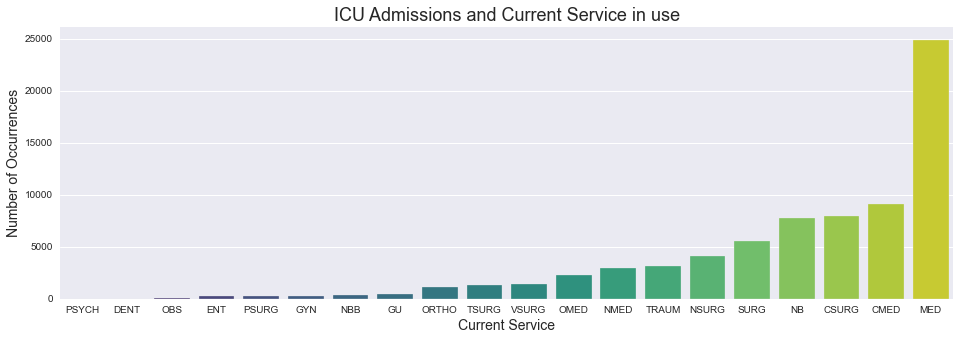

In [33]:
plt.figure(figsize=(16,5))
sns.barplot(df_temp_services.curr_service, df_temp_services.counts, palette= "viridis")
plt.title('ICU Admissions and Current Service in use', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Current Service', fontsize=14)
plt.show()

MED service i.e Medical - general service for internal medicine accounts for the highest number of current service in use which is almost half the number of admissions. It is followed by CMED(Cardiac Medical),CSURG(Cardiac Surgery), NB(Newborn) and SURG(general surgical service) respectively.  
The top 5 unused service in this medical dataset are PSYCH(Psychiatric), DENT(Dental), OBS(Obstetrics), ENT(Ear, nose, and throat) and PSURG(Plastic Surgery). This makes sense, since this is critical care dataset and hence only relevant medical services are in use at these medical facility in general.


Above we can see that the curr_service column gives an abbreviation for the current service. The prev_service column is null, unless the patient had a transfer of service, in which case it identifies the previous service. For example, we can see subject_id = 471 has had at least two service changes: once from TSURG to MED and once from MED back to TSURG (note: there may be more as we have limited this query using LIMIT 10, and you could examine this patient in detail using SELECT * FROM services WHERE subject_id = 471 if you like).

A list of the unique services and their descriptions can be found at: http://mimic.physionet.org/mimictables/services/  

For example, if interested in identifying surgical patients, the recommended method is searching for patients admitted under a surgical service.    

In particular, if we want to exclude surgery, we should exclude patients who were admitted under:  
   
CSURG  
NSURG  
ORTHO  
PSURG  
SURG  
TSURG  
VSURG  
We can simplify this to patients who were under service '%SURG' or 'ORTHO' - where '%' is a wildcard matching any letter(s).

In [34]:
query = query_schema + """
SELECT hadm_id, curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  AS surgical
FROM services se
LIMIT 10
"""
df = pd.read_sql_query(query, con)
df

,hadm_id,curr_service,surgical
0,135879,MED,0
1,135879,TSURG,1
2,173064,CMED,0
3,129194,NB,0
4,194246,NB,0
5,146746,NBB,0
6,139351,NB,0
7,161042,NB,0
8,191025,MED,0
9,137370,NB,0


This seems to be working nicely - except we only have hadm_id, and we are basing our cohort off of icustay_id. No problem, we can join from the icustays table to get the icustay_id for each hadm_id.

### 1.1.3 Applying filter with the ICU Stays and current service as surgery or ortho Only :

In [35]:
query = query_schema + """
SELECT icu.hadm_id, icu.icustay_id, curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  AS surgical
FROM icustays icu
LEFT JOIN services se
  ON icu.hadm_id = se.hadm_id
LIMIT 10
"""
df = pd.read_sql_query(query, con)
df

,hadm_id,icustay_id,curr_service,surgical
0,100001,275225,MED,0
1,100003,209281,MED,0
2,100006,291788,MED,0
3,100006,291788,OMED,0
4,100007,217937,SURG,1
5,100009,253656,CSURG,1
6,100010,271147,GU,0
7,100011,214619,TRAUM,0
8,100012,239289,SURG,1
9,100016,217590,MED,0


Note however that now we have a new issue: which service do we pick for each icustay_id? This is a cohort selection question, not a syntax question. We choose to exclude patients whose last service before ICU admission was surgical. We can update our join clause to reflect this choice:

In [36]:
query = query_schema + """
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  AS surgical
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
LIMIT 10
"""
df = pd.read_sql_query(query, con)
df

,hadm_id,icustay_id,curr_service,surgical
0,100001,275225,MED,0
1,100003,209281,MED,0
2,100006,291788,MED,0
3,100007,217937,SURG,1
4,100009,253656,CSURG,1
5,100010,271147,GU,0
6,100011,214619,TRAUM,0
7,100012,239289,SURG,1
8,100016,217590,MED,0
9,100017,258320,MED,0


Note how icustay_id = 291788 no longer has an entry for OMED above: this is because this service was given after their ICU admission, so we do not want to consider it. Also note that our join clause has + interval '12' hour - this adds a bit of "fuzziness" to our criteria. As these times are entered asynchronously by different people in varying locations in the hospital, there can be some minor inconsistencies in the order. For example, a patient may be transferred to the surgical service for ICU admission, but the transfertime in services occurs after the intime in icustays by an hour or so. This is administrative "noise" - and a fuzzy interval can be useful in these cases. Again, this is a cohort selection decision - you may not want to use an interval as large as 12 hours - perhaps only 2 or 4 - though in this case there is likely to be very minor differences as 80% of patients never have a change in hospital service.

Finally, we want to collapse this down so we only have one service for a given ICU admission. As done earlier, we will use RANK() to do this.

In [37]:
query = query_schema + """
WITH serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  AS surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
LIMIT 10
)
SELECT hadm_id, icustay_id, curr_service, surgical
FROM serv
WHERE rank = 1
"""
df = pd.read_sql_query(query, con)
df

,hadm_id,icustay_id,curr_service,surgical
0,100001,275225,MED,0
1,100003,209281,MED,0
2,100006,291788,MED,0
3,100007,217937,SURG,1
4,100009,253656,CSURG,1
5,100010,271147,GU,0
6,100011,214619,TRAUM,0
7,100012,239289,SURG,1
8,100016,217590,MED,0
9,100017,258320,MED,0


We can join this table to our original cohort from above.

In [38]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
LIMIT 10
)
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , co.icustay_id_order
  
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
"""
df = pd.read_sql_query(query, con)
df

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,6,107064,228232,3.672917,65.942297,1,0,0,0,1
1,7,118037,278444,0.267720,0.001779,1,1,1,0,0
2,7,118037,236754,0.739097,0.005868,2,1,1,1,0
3,3,145834,211552,6.064560,76.526792,1,0,0,0,1
4,9,150750,220597,5.323056,41.790228,1,0,0,0,0
5,8,159514,262299,1.075521,0.001438,1,1,1,0,0
6,2,163353,243653,0.091829,0.002434,1,1,1,0,0
7,5,178980,214757,0.084444,0.000693,1,1,1,0,0
8,10,184167,288409,8.092106,0.001329,1,0,1,0,0
9,4,185777,294638,1.678472,47.845047,1,1,0,0,0


Great! You now have a cohort for which you can start extracting data.

A common question asked is: why did we use the services table for identifying surgical patients, rather than the first_careunit column from the icustays? This is a very important concept in the MIMIC-III database: while patients may be cared for by the surgical service, they are not necessarily in the surgical ICU. These patients are called "boarders", and the reason why they are not in the usual ICU for their service is multifactorial. Let's take a look at some care units:

In [39]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
LIMIT 10
)
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
"""
df = pd.read_sql_query(query, con)
df

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,curr_service,first_careunit,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,6,107064,228232,3.672917,65.942297,1,SURG,SICU,0,0,0,1
1,7,118037,278444,0.267720,0.001779,1,NB,NICU,1,1,0,0
2,7,118037,236754,0.739097,0.005868,2,NB,NICU,1,1,1,0
3,3,145834,211552,6.064560,76.526792,1,VSURG,MICU,0,0,0,1
4,9,150750,220597,5.323056,41.790228,1,NMED,MICU,0,0,0,0
5,8,159514,262299,1.075521,0.001438,1,NB,NICU,1,1,0,0
6,2,163353,243653,0.091829,0.002434,1,NB,NICU,1,1,0,0
7,5,178980,214757,0.084444,0.000693,1,NB,NICU,1,1,0,0
8,10,184167,288409,8.092106,0.001329,1,NB,NICU,0,1,0,0
9,4,185777,294638,1.678472,47.845047,1,MED,MICU,1,0,0,0


Without specifically looking for it, we have found an example in icustay_id 211552: they were admitted under the VSURG service, but admitted to a medical ICU (MICU). If we used the first_careunit, then we would undesirably include this "boarder" in our study.

Let's summarize our exclusions by looking at some simple summary measures of the dataframe df.

In [40]:
print('{:20s} {:5d}'.format('Observations', df.shape[0]))
idxExcl = np.zeros(df.shape[0],dtype=bool)
for col in df.columns:
    if "exclusion_" in col:
        print('{:20s} {:5d} ({:2.2f}%)'.format(col, df[col].sum(), df[col].sum()*100.0/df.shape[0]))
        idxExcl = (idxExcl) | (df[col]==1)

# print a summary of how many were excluded in total
print('')
print('{:20s} {:5d} ({:2.2f}%)'.format('Total excluded', np.sum(idxExcl), np.sum(idxExcl)*100.0/df.shape[0]))

Observations            10
exclusion_los            6 (60.00%)
exclusion_age            6 (60.00%)
exclusion_first_stay     1 (10.00%)
exclusion_surgical       2 (20.00%)

Total excluded           9 (90.00%)


As we can see, summarizing the exclusions is very simple because we have created this cohort table. With that, we conclude this tutorial on cohort selection. To recap, you have learned that:

best practice is to create a "cohort" table with a single row for every unique icustay_id, which is usually the identifier of interest
exclusions flags can be created based off rules, allowing easy prototyping, modification, and summarization later
when identifying the type of care provided, use the services table
read the docs, and don't make assumptions!
Also, remember that when prototyping the LIMIT clause is very useful for speed gains, but don't forget to remove it once you want to test your code on all 60,000+ admissions :)



### 1.1.4 Final selected cohort :

In [41]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
)
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
"""
df_cohort = pd.read_sql_query(query, con)
df_cohort

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,curr_service,first_careunit,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,2,163353,243653,0.091829,0.002434,1,NB,NICU,1,1,0,0
1,3,145834,211552,6.064560,76.526792,1,VSURG,MICU,0,0,0,1
2,4,185777,294638,1.678472,47.845047,1,MED,MICU,1,0,0,0
3,5,178980,214757,0.084444,0.000693,1,NB,NICU,1,1,0,0
4,6,107064,228232,3.672917,65.942297,1,SURG,SICU,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
61529,99985,176670,279638,11.299838,53.814270,1,MED,MICU,0,0,0,0
61530,99991,151118,226241,3.142616,47.729259,1,SURG,TSICU,0,0,0,1
61531,99992,197084,242052,1.974456,65.772155,1,MED,MICU,1,0,0,0
61532,99995,137810,229633,2.161481,88.698942,1,VSURG,CSRU,0,0,0,1


## MIMIC-III tables used in cohort selection:
Following tables were used for the cohort selection :  
ICUSTAYS   
PATIENTS   
SERVICES

In [43]:
# Now we dont want to remove the patients based on the surgical exclusion criteria, lets remove the same :

#df_cohort.drop(['exclusion_surgical'], axis=1)
for col in df_cohort.columns: 
    if 'exclusion_surgical' in col: 
        del df_cohort[col] 

df_cohort.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,curr_service,first_careunit,exclusion_los,exclusion_age,exclusion_first_stay
0,2,163353,243653,0.091829,0.002434,1,NB,NICU,1,1,0
1,3,145834,211552,6.064560,76.526792,1,VSURG,MICU,0,0,0
2,4,185777,294638,1.678472,47.845047,1,MED,MICU,1,0,0
3,5,178980,214757,0.084444,0.000693,1,NB,NICU,1,1,0
4,6,107064,228232,3.672917,65.942297,1,SURG,SICU,0,0,0


In [44]:
print('{:20s} {:5d}'.format('Observations', df_cohort.shape[0]))
df_excl_cohort = np.zeros(df_cohort.shape[0],dtype=bool)
df_incl_cohort = np.ones(df_cohort.shape[0],dtype=bool)
for col in df_cohort.columns:
    if "exclusion_" in col:
        print('{:20s} {:5d} ({:2.2f}%)'.format(col, df_cohort[col].sum(), df_cohort[col].sum()*100.0/df_cohort.shape[0]))
        df_excl_cohort = (df_excl_cohort) | (df_cohort[col]==1)

# print a summary of how many were excluded in total
print('')
print('{:20s} {:5d} ({:2.2f}%)'.format('Total excluded', np.sum(df_excl_cohort), np.sum(df_excl_cohort)*100.0/df_cohort.shape[0]))
print('{:20s} {:5d} ({:2.2f}%)'.format('Total included', (np.sum(df_incl_cohort)-np.sum(df_excl_cohort)), (np.sum(df_incl_cohort)-np.sum(df_excl_cohort))*100.0/df_cohort.shape[0]))

Observations         61534
exclusion_los        29213 (47.47%)
exclusion_age         8109 (13.18%)
exclusion_first_stay 15058 (24.47%)

Total excluded       41157 (66.88%)
Total included       20377 (33.12%)


### Important Observation here regarding the Cohort :

29213 (47.47%) patient records were excluded due to length of stay less than 48 hours, 
8109 (13.18%) patient records were excluded because age was less than 16 years, 
15058 (24.47%) patient records were excluded which had multiple admissions, and 
18225 (29.62%) patient records were excluded where the last operation was not surgery
  
#### 41157 (66.88%) patients records were excluded in total 


### Total of 20377 (33.12%) patients were selected for our study cohort

In [45]:
# Create a dataframe for the selected cohort :

df_cohort['Valid'] = np.where((df_cohort.exclusion_los==0)& (df_cohort.exclusion_age==0)& (df_cohort.exclusion_first_stay==0),1,0)
df_valid_cohort =  df_cohort[(df_cohort.Valid==1)]
df_valid_cohort.head(5)

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,curr_service,first_careunit,exclusion_los,exclusion_age,exclusion_first_stay,Valid
1,3,145834,211552,6.064560,76.526792,1,VSURG,MICU,0,0,0,1
4,6,107064,228232,3.672917,65.942297,1,SURG,SICU,0,0,0,1
8,9,150750,220597,5.323056,41.790228,1,NMED,MICU,0,0,0,1
11,12,112213,232669,7.634815,72.374177,1,SURG,SICU,0,0,0,1
12,13,143045,263738,3.666042,39.866118,1,CMED,CCU,0,0,0,1


In [46]:
# We dont need these exclusion flags and valid flags anymore, getting rid of the same :
not_col_list = ['exclusion_first_stay', 'Valid','exclusion_los','exclusion_age']

df_valid_cohort = df_valid_cohort.drop(not_col_list, axis=1)
df_valid_cohort.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,icustay_id_order,curr_service,first_careunit
1,3,145834,211552,6.064560,76.526792,1,VSURG,MICU
4,6,107064,228232,3.672917,65.942297,1,SURG,SICU
8,9,150750,220597,5.323056,41.790228,1,NMED,MICU
11,12,112213,232669,7.634815,72.374177,1,SURG,SICU
12,13,143045,263738,3.666042,39.866118,1,CMED,CCU


In [47]:
df_valid_cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20377 entries, 1 to 61532
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          20377 non-null  int64  
 1   hadm_id             20377 non-null  int64  
 2   icustay_id          20377 non-null  int64  
 3   icu_length_of_stay  20375 non-null  float64
 4   age                 20377 non-null  float64
 5   icustay_id_order    20377 non-null  int64  
 6   curr_service        19935 non-null  object 
 7   first_careunit      20377 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 1.4+ MB


##### SUBJECT_ID refers to a unique patient,   HADM_ID refers to a unique admission to the hospital, and   ICUSTAY_ID refers to a unique admission to an intensive care unit.

In [51]:
# Finally, we have the required dataframe with the valid cohort information for the 20377 patients. 

In [48]:
# Validating that each icu stay is is unique :
print(f"Distinct entries of ICU Stays: {len(df_valid_cohort.groupby(['icustay_id']))}")

Distinct entries of ICU Stays: 20377


In [49]:
# Validating that each hospital admission is unique :
print(f"Distinct entries of Hospital stays: {len(df_valid_cohort.groupby(['hadm_id']))}")

Distinct entries of Hospital stays: 20377


In [50]:
# Validating that each patient is unique :
print(f"Distinct entries of patients: {len(df_valid_cohort.groupby(['subject_id']))}")

Distinct entries of patients: 20377


As we can see, summarizing the exclusions is very simple because we have created this cohort table. With that, we conclude this tutorial on cohort selection. 

1. best practice is to create a "cohort" table with a single row for every unique *icustay_id*, which is usually the identifier of interest  
2. exclusions flags can be created based off rules, allowing easy prototyping, modification, and summarization later  
3. when identifying the type of care provided, use the services table  
4. read the docs, and don't make assumptions!  

Also, remember that when prototyping the LIMIT clause is very useful for speed gains, but don't forget to remove it once you want to test your code on all 60,000+ admissions

### MIMICIII CPTEVENTS Table :

The CPTEVENTS table contains a list of which current procedural terminology codes were billed for which patients. This can be useful for determining if certain procedures have been performed (e.g. ventilation).

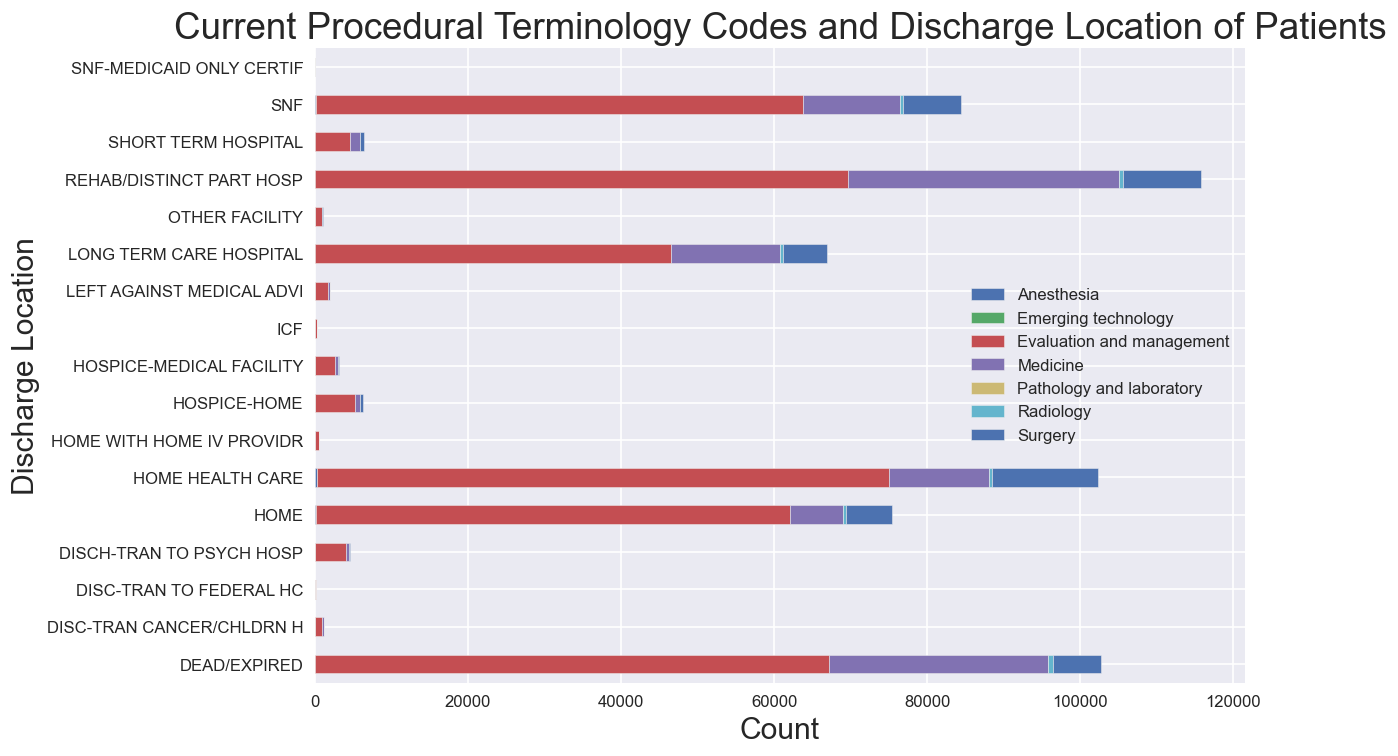

In [51]:
fig = plt.figure(figsize=(10,7), dpi=120)
ax = plt.subplot(111)

c = pd.read_csv(r"C:\mimic-iii-clinical-database-1.4/CPTEVENTS.csv",low_memory=False)
c.columns = map(str.lower, c.columns)

# Merging the ADMISSIONS with CPTEVENTS table:
ac = pd.merge(a, c, on = 'hadm_id' , how = 'inner')
ac.groupby(['discharge_location','sectionheader']).size().unstack().plot(kind="barh", stacked=True, ax=ax)

# Use specific style :
plt.style.use('bmh')

plt.ylabel("Discharge Location",size=18)
plt.xlabel("Count",size=18)
plt.title("Current Procedural Terminology Codes and Discharge Location of Patients",size=22)
# plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))

plt.legend(loc='right',
           fancybox=True, shadow=True)
plt.show()

The highest discharge location as the outcome of the admissions are **Rehabilitation/Different Hospital parts** followed by **Dead/expired outcome and Home Health Care.**  
Most times were spent in the **Evaluation and Management of the cases, followed by Medication and Surgery** repectively of the patients. 


### MIMICIII NOTEEVENTS Table : 

Contains all notes for the patients.  
https://github.com/mghassem/medicationCategories

### Medication categories - Python script for extracting medications from free-text notes  

Quick script to parse out medications from discharge summaries in MIMIC format. Note that this approach is brute force: it uses minimal NLP, and can be vastly improved.  
Following files are needed with the code for this analysis :  
#### Input files:
1. MISC_list.txt : list of additional drugs to search for 
2. SSRI_list.txt : list of SSRI drugs to search for
3. finddrugs.py
  


#### Output file :
output.csv  
***Please remove the output file is the file with the same name already exists in the current execution directory***

**SSRI** - Selective serotonin reuptake inhibitors are a class of drugs that are typically used as antidepressants in the treatment of major depressive disorder, anxiety disorders, and other psychological conditions.

https://www.mayoclinic.org/diseases-conditions/depression/in-depth/ssris/art-20044825  
The Food and Drug Administration (FDA) has approved these SSRIs to treat depression:  
Citalopram|Celexa  
Escitalopram|Lexapro  
Fluoxetine|Prozac|Serafem|Selfemra  
Fluvoxamine|Luvox  
Paroxetine|Paxil|Pexeva  
Sertraline|Zoloft  

These medications were included in the list of the SSRI drugs in the txt file.  
Similarly specific medicines can be added in the file MISC_list.txt which we want to look out for. 

In [52]:
# Import the Custom finddrugs module:
import finddrugs

# Get the notes to be analysed from NOTEEVENTS table :

query = query_schema + """
SELECT n.row_id, n.subject_id, n.hadm_id, n.category, n.description, n.text
FROM noteevents n
WHERE n.category like 'Discharge summary';
"""

notevents_summary_data = pd.read_sql_query(query, con)

In [53]:
# Top 5 rows of data of NOTEEVENTS Discharge Summary text:
notevents_summary_data.head()

,row_id,subject_id,hadm_id,category,description,text
0,174,22532,167853,Discharge summary,Report,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,Discharge summary,Report,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,Discharge summary,Report,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,Discharge summary,Report,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,Discharge summary,Report,Admission Date: [**2162-3-3**] D...


In [56]:
# Search the notes: 
finddrugs.search(notevents_summary_data)

Using drugs from C:\Users\91890\SSRI_list.txt
Using additional drugs from C:\Users\91890\MISC_list.txt
Reading documents...
...index: 0. row_id: 174. subject_id: 22532. hadm_id: 167853. 

...index: 100. row_id: 25. subject_id: 57578. hadm_id: 158315. 

...index: 200. row_id: 112. subject_id: 89633. hadm_id: 140269. 

...index: 300. row_id: 302. subject_id: 14787. hadm_id: 114814. 

...index: 400. row_id: 733. subject_id: 11567. hadm_id: 108828. 

...index: 500. row_id: 510. subject_id: 12272. hadm_id: 132957. 

...index: 600. row_id: 386. subject_id: 19599. hadm_id: 172617. 

...index: 700. row_id: 890. subject_id: 20088. hadm_id: 137881. 

...index: 800. row_id: 824. subject_id: 86791. hadm_id: 160041. 

...index: 900. row_id: 587. subject_id: 16628. hadm_id: 134082. 

...index: 1000. row_id: 1163. subject_id: 76558. hadm_id: 119695. 

...index: 1100. row_id: 1609. subject_id: 21393. hadm_id: 187249. 

...index: 1200. row_id: 972. subject_id: 32649. hadm_id: 120849. 

...index: 1300. 

In [59]:
# Above query sually takes 2-3 minutes to finish up.

In [57]:
# load the output to a dataframe
medications = pd.read_csv('output.csv')
medications.head()

,ROW_ID,SUBJECT_ID,HADM_ID,HIST_FOUND,DEPRESSION,ADMIT_FOUND,DIS_FOUND,GEN_DEPRESS_MEDS_FOUND,GROUP,SSRI,MISC,citalopram,escitalopram,fluoxetine,fluvoxamine,paroxetine,sertraline
0,174,22532,167853,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,175,13702,107527,1,0,1,1,0,3,1,0,0,1,0,0,0,0
2,176,13702,167118,1,1,1,1,0,3,1,0,0,1,0,0,0,0
3,177,13702,196489,1,1,1,1,0,3,1,0,0,1,0,0,0,0
4,178,26880,135453,1,0,1,1,0,3,1,0,1,0,0,0,0,0


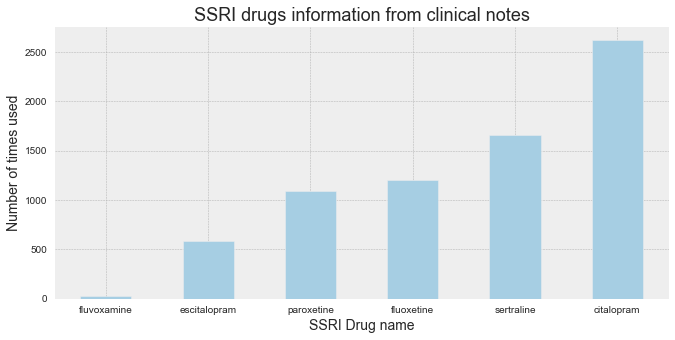

In [58]:
drugs_list = ['citalopram','escitalopram','fluoxetine','fluvoxamine','paroxetine','sertraline']
sorted_SSRI_med = medications[drugs_list].sum()

fig = plt.figure(figsize=(11,5))
plt.title("SSRI drugs information from clinical notes", size =18)
plt.xlabel("SSRI Drug name", size= 14)
plt.ylabel("Number of times used", size = 14)
#plt.figsize
ax = sorted_SSRI_med.sort_values().plot.bar(rot=0, colormap='Paired')
plt.show()

The top 2 most preferred SSRI drug administered for the patients are **citalopram** and **sertraline**.  
The least preferred SSRI drug used is fluvoxamine.     

## Using FIDDLE for EHR data preprocessing :

https://pubmed.ncbi.nlm.nih.gov/33040151/  
https://gitlab.eecs.umich.edu/mld3/FIDDLE  

**FIDDLE – FlexIble Data-Driven pipeLinE** – is a preprocessing pipeline that transforms structured EHR data into feature vectors that can be used with ML algorithms, relying on only a small number of user-defined arguments.  
A python based package for a FlexIble Data-Driven pipeLinE (FIDDLE), transforming structured EHR data into a machine learning friendly format.

In [ ]:
# close out the database connection
con.close()